In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.simulation.physics import get_data, physics_ODE_simulation
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import partconv1d, get_gaussian_kernel
from bcnf.eval.calibration import compute_y_hat_ranks, compute_CDF_residuals
from bcnf.utils import get_dir
from bcnf.simulation.sampling import generate_data

In [3]:
param_names = ['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z','g','w_x','w_y','w_z','b','A','Cd','rho','m','a_x','a_y','a_z','r']

In [4]:
dataset_name = "preliminary_data_4s"

if not os.path.exists(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl')):
    data = generate_data(
        n=2000,
        type="trajectory",
        SPF=1/30,
        T=3,
        config_file=os.path.join(get_dir("configs"), "throw_upwards_no_a.yaml"),
        verbose=True,
        break_on_impact=False,
        name=dataset_name
    )
else:
    with open(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl'), 'rb') as f:
        data = pickle.load(f)

In [5]:
data.keys()

dict_keys(['cams', 'traj', 'x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g', 'w_x', 'w_y', 'w_z', 'b', 'A', 'Cd', 'rho', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian', 'r', 'cam_radius', 'cam_angles', 'cam_heights'])

In [6]:
# dict_keys(['cams', 'traj', 'x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g', 'w_x', 'w_y', 'w_z', 'b', 'A', 'Cd', 'rho', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian', 'r', 'cam_radius', 'cam_angles', 'cam_heights'])

X_list = [
    physics_ODE_simulation(
        np.array([x01, x02, x03]),
        np.array([v01, v02, v03]), g,
        np.array([w01, w02, w03]), b, m, rho, r,
        np.array([0, 0, 0]), T=2, dt=1/100, break_on_impact=False)
          for x01, x02, x03, v01, v02, v03, g, w01, w02, w03, b, m, rho, r, a01, a02, a03 in tqdm(zip(
        data['x0_x'], data['x0_y'], data['x0_z'],
        data['v0_x'], data['v0_y'], data['v0_z'],
        data['g'], data['w_x'], data['w_y'], data['w_z'],
        data['b'], data['m'], data['rho'], data['r'],
        data['a_x'], data['a_y'], data['a_z']
    ))]

2000it [00:02, 957.78it/s] 


In [7]:
np.array(X_list).shape

(2000, 200, 3)

In [8]:
# X, y = get_data(
#     T=2.0,
#     dt=1 / 100,
#     N=5_00,
#     break_on_impact=False
# )


# X = np.array(data['traj'])
X = np.array(X_list)
y = np.column_stack([np.array(data[param]) for param in param_names])

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=2024_03_25)

# Standardize data
# scaler_X = StandardScaler().fit(X_train)

# X_train = scaler_X.transform(X_train)
# X_val = scaler_X.transform(X_val)

print(f'{X_train.shape=}')
print(f'{X_val.shape=}')
print(f'{y_train.shape=}')
print(f'{y_val.shape=}')


X_train.shape=(1600, 600)
X_val.shape=(400, 600)
y_train.shape=(1600, 19)
y_val.shape=(400, 19)


In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([1600, 600])
y_train_tensor.shape=torch.Size([1600, 19])
X_val_tensor.shape=torch.Size([400, 600])
y_val_tensor.shape=torch.Size([400, 19])


In [10]:
condition_size = 1360

In [11]:
feature_network = FullyConnectedFeatureNetwork(
    sizes = [X_train_tensor.shape[1]] + [212] * 7 + [condition_size],
    dropout=0.111,
).to(device)

In [12]:
cnf = CondRealNVP(
    size=y_train.shape[1],
    nested_sizes=[526] * 5,
    n_blocks=26,
    dropout=0.407,
    n_conditions=condition_size,
    act_norm=True,
    feature_network=feature_network).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=2e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=250, threshold_mode="abs", threshold=1e-1
)

In [13]:
print(f'Number of parameters: {sum(p.numel() for p in cnf.parameters()):.2e}')

Number of parameters: 4.85e+07


In [14]:
loss_history = {}

In [15]:
train_CondRealNVP(
    model=cnf,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    n_epochs=1000,
    val_loss_patience=500,
    val_loss_tolerance=1e-1,
    val_loss_tolerance_mode="abs",
    batch_size=256,
    loss_history=loss_history
);

Train: -14.7534 - Val: -16.6874 (avg: -16.7260, min: -16.6975) | lr: 2.00e-04 - Patience: 5/500: 100%|██████████| 1000/1000 [09:26<00:00,  1.76it/s]


In [16]:
cnf.eval();

In [17]:
N_SAMPLES = 10000

In [83]:
resimulation_index = 8

In [84]:
X_val.reshape(-1, 200, 3)[resimulation_index, :, -1]

array([ 1.00162024,  1.05967332,  1.11669638,  1.17269558,  1.22767685,
        1.28164589,  1.33460814,  1.38656885,  1.43753302,  1.48750545,
        1.53649075,  1.5844933 ,  1.63151729,  1.67756675,  1.72264547,
        1.76675712,  1.80990516,  1.85209289,  1.89332345,  1.93359982,
        1.97292483,  2.01130116,  2.04873136,  2.08521782,  2.1207628 ,
        2.15536846,  2.1890368 ,  2.22176973,  2.25356902,  2.28443635,
        2.31437329,  2.34338129,  2.37146173,  2.39861587,  2.4248449 ,
        2.45014992,  2.47453194,  2.49799189,  2.52053064,  2.54214898,
        2.56284762,  2.58262723,  2.6014884 ,  2.61943168,  2.63645754,
        2.65256643,  2.66775872,  2.68203477,  2.69539486,  2.70783926,
        2.7193682 ,  2.72998186,  2.73968041,  2.74846398,  2.75633269,
        2.76328661,  2.76932582,  2.77445036,  2.77866028,  2.7819556 ,
        2.78433633,  2.78580248,  2.78635405,  2.78599105,  2.78471347,
        2.78252132,  2.77941461,  2.77539334,  2.77045753,  2.76

In [85]:
y_hat = cnf.sample(n_samples=N_SAMPLES, y=X_val_tensor[resimulation_index])
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

(10000, 19)

In [86]:
y_prior = y_train_tensor.to('cpu').detach().numpy()

In [87]:
from bcnf.simulation.physics import physics_ODE_simulation

In [88]:
data.keys()

dict_keys(['cams', 'traj', 'x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g', 'w_x', 'w_y', 'w_z', 'b', 'A', 'Cd', 'rho', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian', 'r', 'cam_radius', 'cam_angles', 'cam_heights'])

In [89]:
['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z','g','w_x','w_y','w_z','b','A','Cd','rho','m','a_x','a_y','a_z','r'][18]

'r'

In [90]:

X_resimulation = np.empty((N_SAMPLES, 200, 3))

for i in tqdm(range(N_SAMPLES)):
    X_resimulation[i] = physics_ODE_simulation(
        x0=y_hat[i, :3],
        v0=y_hat[i, 3:6],
        g=y_hat[i, 6],
        w=y_hat[i, 7:10],
        b=y_hat[i, 10],
        m=y_hat[i, 14],
        rho=y_hat[i, 13],
        r=y_hat[i, 18],
        a=y_hat[i, 15:18],
        T=2,
        dt=1/100,
        break_on_impact=False
    )

  0%|          | 0/10000 [00:00<?, ?it/s]/home/psaegert/Projects/bcnf/src/bcnf/simulation/physics.py:43: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  v_sol = odeint(ballistic_ODE, v0, t, args=(g, w, b, m, rho, r, a))
100%|██████████| 10000/10000 [00:17<00:00, 560.40it/s]


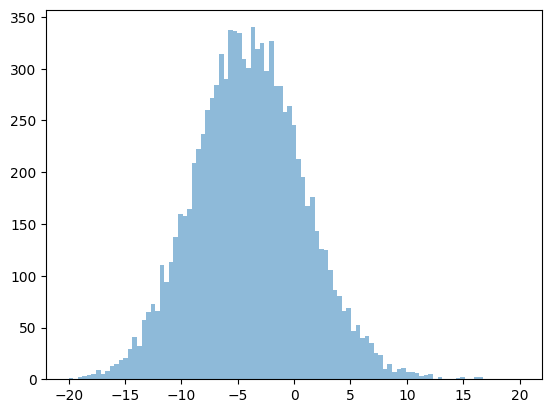

In [91]:
plt.hist(X_resimulation[:, -1, -1], bins=np.linspace(-20, 20, 100), alpha=0.5, label='Resimulation');

In [92]:
# Find the indices [:, i, :] where X_resimulation changes sign from positive to negative
impact_indices = np.where(np.diff((X_resimulation[:, :, -1] > 0).astype(int), axis=1) == -1)

In [93]:
true_impact_indices = np.where(np.diff((X_val.reshape(-1, 200, 3)[resimulation_index, :, -1] > 0).astype(int)) == -1)

In [94]:
X_val.reshape(-1, 200, 3)[resimulation_index, true_impact_indices[0], 0]

array([5.87754154])

In [95]:
X_val.reshape(-1, 200, 3)[resimulation_index, true_impact_indices[0], 0]

array([5.87754154])

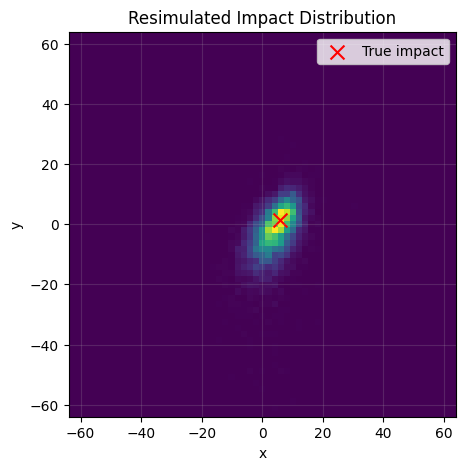

In [96]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(X_resimulation[impact_indices[0], impact_indices[1], 0], X_resimulation[impact_indices[0], impact_indices[1], 1], bins=np.linspace(-64, 64, 64), cmap='viridis');
ax.scatter(
    X_val.reshape(-1, 200, 3)[resimulation_index, true_impact_indices[0], 0],
    X_val.reshape(-1, 200, 3)[resimulation_index, true_impact_indices[0], 1],
    color='red', s=100, marker='x', label='True impact')
ax.grid(axis='both', alpha=0.2);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_title('Resimulated Impact Distribution');
ax.legend();

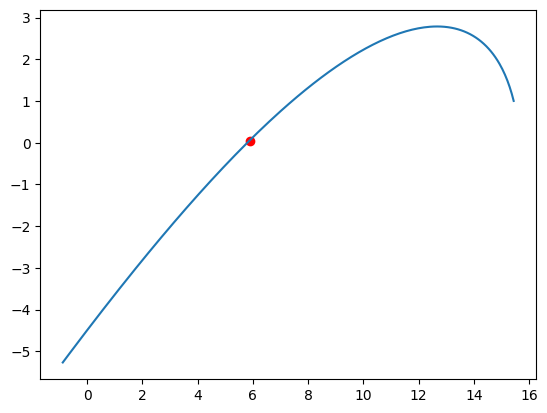

In [97]:
plt.plot(X_val.reshape(-1, 200, 3)[resimulation_index, :, 0], X_val.reshape(-1, 200, 3)[resimulation_index, :, -1], label='True trajectory');
plt.scatter(X_val.reshape(-1, 200, 3)[resimulation_index, true_impact_indices[0], 0], X_val.reshape(-1, 200, 3)[resimulation_index, true_impact_indices[0], -1], color='red', label='Impact');

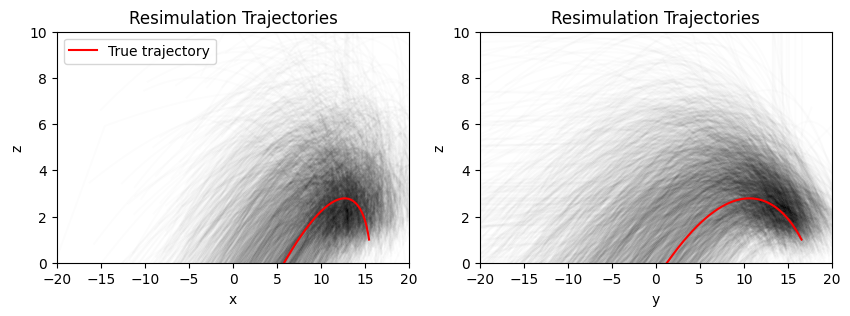

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

n_trajectories = 2500

for i, (ax, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    ax.plot(X_resimulation[:n_trajectories, :, i].T, X_resimulation[:n_trajectories, :, -1].T, alpha=0.01, color='black');
    ax.plot(X_val.reshape(-1, 200, 3)[resimulation_index, :, i], X_val.reshape(-1, 200, 3)[resimulation_index, :, -1], label='True trajectory', color='red');
    # ax.scatter(X_resimulation[impact_indices[0], impact_indices[1], 0], X_resimulation[impact_indices[0], impact_indices[1], -1], color='red', s=10, alpha=0.5);
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0, 10)
    ax.set_xlabel(ax_name);
    ax.set_ylabel('z');
    ax.set_title('Resimulation Trajectories');

axes[0].legend();